In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sample = pd.read_csv("sample_submission.csv")
sample

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


In [3]:
# what we are predicting, x_test
# row_id is stock_id + time_id
sample_test = pd.read_csv("test.csv")
sample_test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [20]:
# what is the training data
sample_train = pd.read_csv("train.csv")
sample_train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [9]:
# what's inside book and training data
book_example = pd.read_parquet('book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet('trade_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id

In [19]:
# stock_id = 0 and time_id = 5
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
297,5,585,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0
298,5,586,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0
299,5,587,1.003129,1.003749,1.003025,1.003801,100,3,26,3,0
300,5,588,1.003129,1.003749,1.002612,1.003801,100,3,2,3,0


In [12]:
trade_example.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


# EDA

# Training data

In [24]:
# since test data only has 3 entities, we will split "training" data 80-20 for our training and testing data
# more specifically, for all stocks time_id greater than 26214 will be testing data
max_time_id = max(sample_train['time_id'])
training = sample_train[sample_train['time_id']<= max_time_id*0.8]
testing = sample_train[sample_train['time_id']> max_time_id*0.8]

In [27]:
for col in training.columns:
    print(col, ":", len(training[col].unique()))

stock_id : 112
time_id : 3126
target : 340335


In [30]:
training.describe()

,stock_id,time_id,target
count,350088.000000,350088.000000,350088.000000
mean,62.437693,13009.809582,0.003897
std,37.126570,7530.090046,0.002967
min,0.000000,5.000000,0.000105
25%,30.000000,6403.000000,0.002035
50%,62.500000,13124.000000,0.003059
75%,96.000000,19373.000000,0.004745
max,126.000000,26208.000000,0.070321


In [34]:
# statistics by stocks
stocks = training.groupby("stock_id")["target"].agg(['mean','median','std','count','sum','min','max']).reset_index()
stocks

,stock_id,mean,median,std,count,sum,min,max
0,0,0.004052,0.003184,0.002922,3126,12.667570,0.000594,0.036311
1,1,0.004372,0.003730,0.002437,3126,13.665789,0.000916,0.020951
2,2,0.002407,0.001768,0.002411,3126,7.524800,0.000394,0.024848
3,3,0.006172,0.005438,0.003157,3126,19.292637,0.000746,0.029127
4,4,0.004229,0.003428,0.002934,3126,13.221214,0.000810,0.025648
...,...,...,...,...,...,...,...,...
107,122,0.003774,0.003182,0.002327,3126,11.797772,0.000861,0.022916
108,123,0.002512,0.001974,0.001828,3126,7.851881,0.000456,0.017907
109,124,0.003701,0.003154,0.001971,3126,11.567808,0.001064,0.019407
110,125,0.002032,0.001584,0.001748,3126,6.350813,0.000344,0.024615


(array([ 5., 23., 27., 21., 19.,  8.,  3.,  4.,  1.,  1.]),
 array([0.00148571, 0.0022079 , 0.00293008, 0.00365227, 0.00437446,
        0.00509664, 0.00581883, 0.00654101, 0.0072632 , 0.00798538,
        0.00870757]),
 <BarContainer object of 10 artists>)

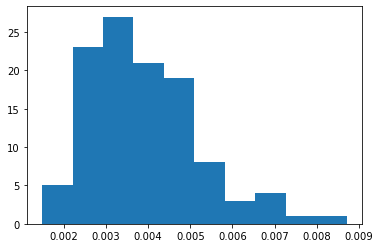

In [35]:
# mean overall is 0.003897
plt.hist(stocks['mean'])

# Book and Trade data

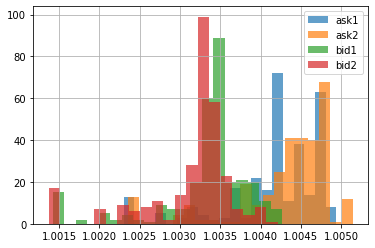

In [92]:
# quick check of book data
book_example.ask_price1.hist(bins = 20, label="ask1", alpha = 0.7)
book_example.ask_price2.hist(bins = 20, label="ask2", alpha = 0.7)
book_example.bid_price1.hist(bins = 20, label="bid1", alpha = 0.7)
book_example.bid_price2.hist(bins = 20, label="bid2", alpha = 0.7)
plt.legend()
plt.show()

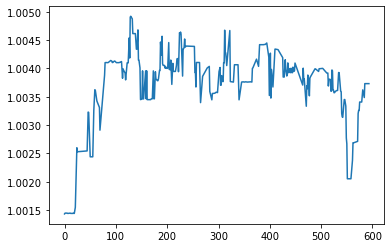

In [38]:
# calculate the weighted average price from book data
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])
plt.plot(book_example['seconds_in_bucket'], book_example['wap'], label="WAP by calculation")
plt.show()

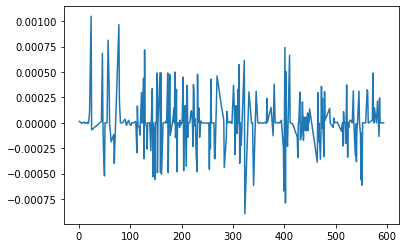

In [44]:
# calculate the log return of WAP
book_example['log_return'] = np.log(book_example['wap']).diff()

plt.plot(book_example['seconds_in_bucket'], book_example['log_return'], label="log return by WAP")
plt.show()

In [59]:
# realized volatility by book data for stock_id = 0, time_id = 5
realized_vol = np.sqrt(np.sum(book_example["log_return"]**2))
print("realized volatility by book data:", realized_vol)

# target value for stock_id = 0, time_id = 5
print("target value in trainng data:", training['target'][0])

realized volatility by book data: 0.004499364172786559
target value in trainng data: 0.004135767


In [98]:
def plot_bid_ask_vol(book_example): 
    prices = ["bid_price1","bid_price2","ask_price1","ask_price2"]
    sizes = ["bid_size1","bid_size2","ask_size1","ask_size2"]

    for ind, val in enumerate(prices):
        plt.figure(figsize = (10,7))

        plt.subplot(8,1,2*ind+1)

        plt.plot(book_example["seconds_in_bucket"],book_example[val],label=val)
        plt.legend(loc='upper right', borderaxespad=0)

        plt.subplot(8,1,2*ind+2)

        plt.bar(book_example["seconds_in_bucket"],book_example[sizes[ind]],color='r',label=sizes[ind])
        plt.legend(loc='upper right', borderaxespad=0)
    plt.show()

In [99]:
def plot_bid_ask_trade(book_example, trade_example):
    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)

    for ind, val in enumerate(prices):
        plt.plot(book_example["seconds_in_bucket"],book_example[val],label=val, alpha = 0.4)    

    plt.plot(trade_example["seconds_in_bucket"],trade_example["price"],label="trade")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.subplot(2,1,2)

    plt.bar(trade_example["seconds_in_bucket"],trade_example["size"],label="trade_size",color ="green")  
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

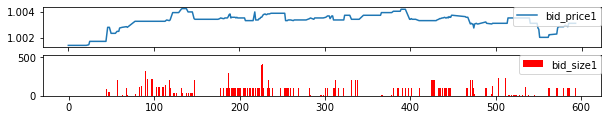

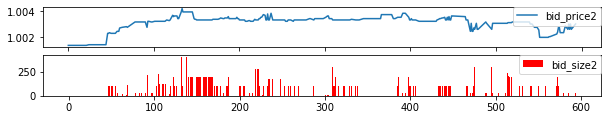

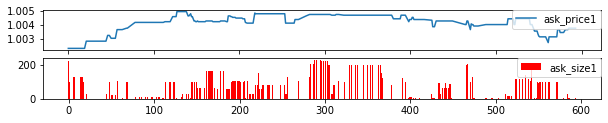

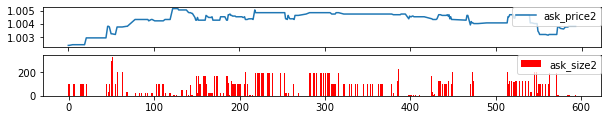

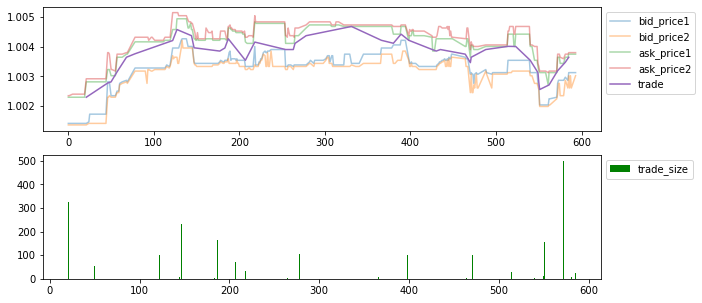

In [100]:
plot_bid_ask_vol(book_example)
plot_bid_ask_trade(book_example, trade_example)

In [93]:
# zoom in to high vol and low vol data for stock_id = 0
training_example = training[training['stock_id'] == 0] 
max_vol_time = training_example.iloc[training_example['target'].idxmax()]

max_vol_time

stock_id        0.000000
time_id     19725.000000
target          0.036311
Name: 2394, dtype: float64

In [94]:
min_vol_time = training_example.iloc[training_example['target'].idxmin()]
min_vol_time

stock_id        0.000000
time_id     24253.000000
target          0.000594
Name: 2901, dtype: float64

In [101]:
# plot when vol is high
book_example_max = pd.read_parquet('book_train.parquet/stock_id=0')
book_example_max=book_example_max[book_example_max['time_id']==max_vol_time.time_id]
trade_example_max = pd.read_parquet('trade_train.parquet/stock_id=0')
trade_example_max=trade_example_max[trade_example_max['time_id']==max_vol_time.time_id]

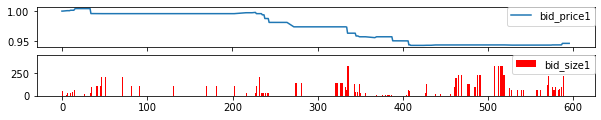

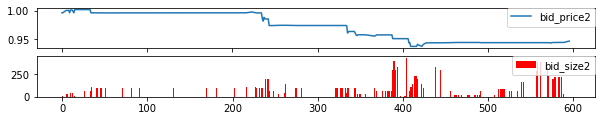

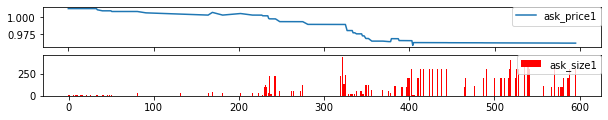

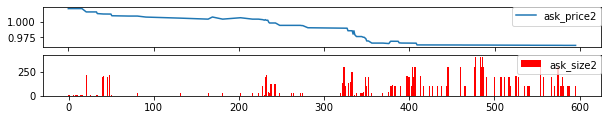

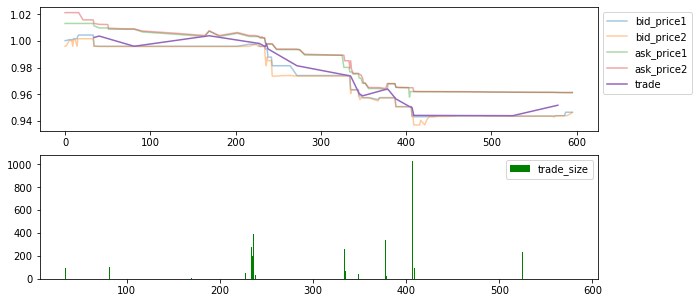

In [102]:
plot_bid_ask_vol(book_example_max)
plot_bid_ask_trade(book_example_max, trade_example_max)

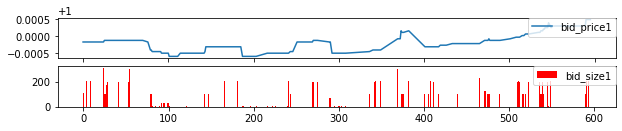

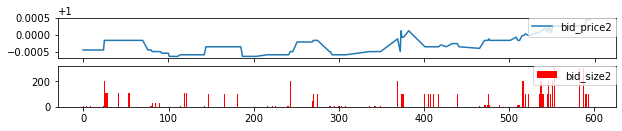

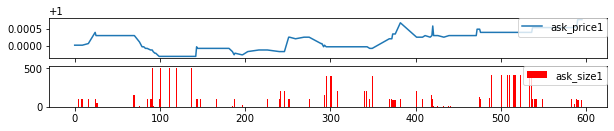

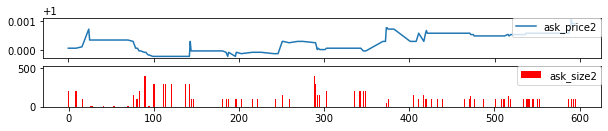

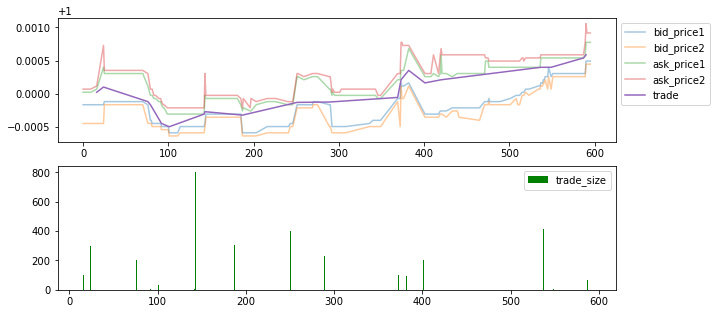

In [103]:
# plot when vol is low
book_example_min = pd.read_parquet('book_train.parquet/stock_id=0')
book_example_min=book_example_min[book_example_min['time_id']==min_vol_time.time_id]
trade_example_min = pd.read_parquet('trade_train.parquet/stock_id=0')
trade_example_min=trade_example_min[trade_example_min['time_id']==min_vol_time.time_id]

plot_bid_ask_vol(book_example_min)
plot_bid_ask_trade(book_example_min, trade_example_min)